In [1]:
# Check the data
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
station="28079004"

In [3]:
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")

In [5]:
# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

In [6]:
tdf = df[["DATE","SPA.NO2"]].copy()
tdf.columns = ["DATE","NO2"]

<AxesSubplot:>

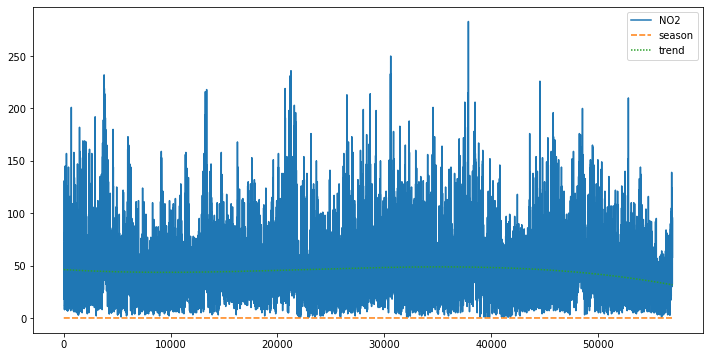

In [20]:
from numpy import polyfit

def fit(X, y, degree=4):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_season(s, period=52, degree=1):
    X = [i%(period) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)

def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

import seaborn as sns
plt.figure(figsize=(12, 6))
tdf['trend'] = get_trend(tdf['NO2'])
tdf['week_season'] = get_season(tdf['NO2'] - tdf['trend'],24,7)

sns.lineplot(data=tdf[['NO2', 'season', 'trend']])

In [20]:
horizon = 13

In [21]:
sel = np.concatenate([[1,2,3,4],
                         [12],
                         24*np.arange(1,9),
                         12+24*np.arange(1,9)])  

sel=np.concatenate([sel,sel-1,sel+1])  
    
## lagged NO2 values
for i in sel:
    if (i>=horizon):
        tdf["NO2 - "+str(i)] = tdf["NO2"].shift(i).copy()

In [23]:
tdf=tdf.dropna()

In [24]:
import mlflow
mlflow.lightgbm.autolog()

In [29]:
# Training/Test
tdf_train = tdf[tdf["DATE"]<"2020"]
tdf_test = tdf[tdf["DATE"]>"2019"]

X_train = tdf_train.drop(columns=['NO2',"DATE"])
X_test = tdf_test.drop(columns=['NO2',"DATE"])
y_train = tdf_train["NO2"]
y_test = tdf_test["NO2"]

# Scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from datetime import datetime

with mlflow.start_run(run_name="LightGBM") as run:
    mlflow.log_param("features", X_train.columns)
    mlflow.log_param("architecture", "lightgbm")
    mlflow.log_param("station", station)
    mlflow.log_param("train-test", f'{tdf["DATE"].min()}-2019-{tdf["DATE"].max()}')

    lgbmodel = lgb.LGBMRegressor(n_estimators=1600,random_state=2020,max_depth=6)

    start = datetime.now().timestamp()
    lgbmodel.fit(X_train_std,y_train)
    end = datetime.now().timestamp()
    mlflow.log_metric("training_time", end-start)
    
    predictions = lgbmodel.predict(X_test_std)
    # RMSE
    mlflow.log_metric("rmse", np.sqrt(mean_squared_error(predictions,y_test)))
    # BIAS
    mlflow.log_metric("bias", np.mean(predictions-y_test))
    # MAPE
    mlflow.log_metric("mape", np.mean(np.abs((y_test-predictions)/(y_test))))

In [30]:
runs_df = mlflow.search_runs("0")

In [31]:
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.bias,metrics.mape,metrics.mean_squared_error_X_test_std,metrics.rmse,...,params.boosting_type,params.reg_lambda,params.verbose,params.features,params.subsample_freq,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.log-model.history
0,b1b691d278294232ae39b70985b37d76,0,FINISHED,file:///home/sebas/Documents/projects/exp_arti...,2022-07-20 11:32:10.125000+00:00,2022-07-20 11:32:19.388000+00:00,5.355787,0.578655,284.481750,16.866587,...,gbdt,0.0,-1,"Index(['NO2 - 24', 'NO2 - 48', 'NO2 - 72', 'NO...",0,LightGBM,sebas,/home/sebas/miniconda3/envs/phd/lib/python3.10...,LOCAL,"[{""run_id"": ""b1b691d278294232ae39b70985b37d76""..."
1,3328bfc0e61547498c7bd557acfb15d3,0,FINISHED,file:///home/sebas/Documents/projects/exp_arti...,2022-07-20 11:26:27.695000+00:00,2022-07-20 11:26:37.051000+00:00,5.543123,0.573890,272.429743,16.505446,...,gbdt,0.0,-1,"Index(['NO2 - 24', 'NO2 - 48', 'NO2 - 72', 'NO...",0,LightGBM,sebas,/home/sebas/miniconda3/envs/phd/lib/python3.10...,LOCAL,"[{""run_id"": ""3328bfc0e61547498c7bd557acfb15d3""..."
2,0016dd090b5d4d66b2d6abe73c791297,0,FINISHED,file:///home/sebas/Documents/projects/exp_arti...,2022-07-20 11:25:55.552000+00:00,2022-07-20 11:26:04.071000+00:00,5.975779,0.651860,324.436498,18.012121,...,gbdt,0.0,-1,"Index(['NO2 - 24', 'NO2 - 48', 'NO2 - 72', 'NO...",0,LightGBM,sebas,/home/sebas/miniconda3/envs/phd/lib/python3.10...,LOCAL,"[{""run_id"": ""0016dd090b5d4d66b2d6abe73c791297""..."


In [28]:
#plt.plot(y_test[-100:].values)
#plt.plot(predictions[-100:])
#plt.plot(y_test.values)
#plt.plot(predictions,c="orange")